In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import scipy
import torch

from typing import Tuple

# Simulating data

## Setting up functions

We can write the magnetic field at a point $(x,y,z)$ from a dipole labeled $i$ in the following manner:
$$
R(\theta, \phi) = \begin{pmatrix} \cos\theta\cos\phi & -\cos\theta\sin\phi & \sin\theta \\
                                  \sin\phi & \cos\phi & 0 \\
                                  -\sin\theta\cos\phi & \sin\theta\sin\phi & \cos\theta \end{pmatrix} 
$$
$$
\vec{B}_i(x, y, z) = R(\theta, \phi)^{-1} \begin{pmatrix} B_{x}'(x, y, z) \\ B_{y}'(x, y, z) \\ B_{z}'(x, y, z) \end{pmatrix} _i
$$
$$
\begin{pmatrix} B_x' \\ B_y' \\ B_z' \end{pmatrix}_i = \begin{pmatrix} \frac{3m_i\mu_0}{4\pi}\frac{(x-x_0)(z-z_0)}{r'^5} \\  \frac{3m_i\mu_0}{4\pi}\frac{(y-y_0)(z-z_0)}{r'^5} \\  \frac{m_i\mu_0}{4\pi}\frac{3(z-z_0)^2 - r'^2}{r'^5} \end{pmatrix}
$$
where $(\theta, \phi)$ are angles specifying the orientation of the dipole, $(x_0, y_0, z_0)$ is its center coordinate, and $r'=\sqrt{(x-x_0)^2 + (y-y_0)^2 + (z-z_0)^2}$

In [3]:
mu0 =  1.25663706127*1e-6
nm = 1e-9

def rot_vec(angle_pairs: np.ndarray) -> np.ndarray:
    theta_arr = angle_pairs[:,0]
    phi_arr = angle_pairs[:,1]
    res_mat = np.ones((len(angle_pairs), 3, 3))
    
    res_mat[:,0,0] = np.cos(theta_arr)*np.cos(phi_arr)
    res_mat[:,0,1] = -np.cos(theta_arr)*np.sin(phi_arr)
    res_mat[:,0,2] =  np.sin(theta_arr)
    res_mat[:,1,0] = np.sin(phi_arr)
    res_mat[:,1,1] =  np.cos(phi_arr)
    res_mat[:,1,2] = np.zeros_like(phi_arr)
    res_mat[:,2,0] = -np.sin(theta_arr)*np.cos(phi_arr)
    res_mat[:,2,1] = np.sin(theta_arr)*np.sin(phi_arr)
    res_mat[:,2,2] = np.cos(theta_arr)
    
    return res_mat

def B_i_vec_3(m_vec: np.ndarray, 
              coord_calc_vec: np.ndarray, 
              coord_center_vec: np.ndarray, 
              angle_pairs: np.ndarray
             ) -> np.ndarray: 
    n_angles = len(angle_pairs)
    n_coords = len(coord_calc_vec)
    
    coords_tuple = np.array(list(map(np.copy, [coord_calc_vec] * n_angles)))
    coords_extended = coords_tuple.reshape((n_coords*n_angles, 3, 1))
    idx_reord = np.array([n_angles*np.arange(n_coords) + ia for ia in range(n_angles)])# np.concatenate((3*np.arange(n_coords), 3*np.arange(n_coords) + 1, 3*np.arange(n_coords) + 2))
    idx_reord = np.concatenate(idx_reord)
    coord_calc_extended = coords_extended[idx_reord, :,:]
    
    coords0_tuple = np.array(list(map(np.copy, [coord_center_vec] * n_coords)))
    coords0_extended = coords0_tuple.reshape((n_coords*n_angles, 3, 1))
    
    coords_diff_arr = coord_calc_extended - coords0_extended # dims n_coords*n_angles x 3 x 1
    
    rot_mats = rot_vec(angle_pairs)
    rot_mats_inv = np.array([np.linalg.inv(mat) for mat in rot_mats])
    rot_mats_tuple = np.array(list(map(np.copy, [rot_mats_inv] * n_coords)))
    rot_mats_extended = rot_mats_tuple.reshape((n_coords*n_angles, 3, 3))

    r_diff_arr = np.sqrt(np.power(coords_diff_arr[:,0,:], 2) + np.power(coords_diff_arr[:,1,:], 2) + np.power(coords_diff_arr[:,2,:], 2))
    
    m_vec_tuple = np.array(list(map(np.copy, [m_vec] * n_coords)))
    m_vec_extended = m_vec_tuple.reshape((n_angles*n_coords, 1))
    
    # dims of coords_diff_arr: n_angles*n_coords x 3 x 1
    # dims of r_diff_arr: n_angles*n_coords x 1
    # dims of m_vec: n_angles*n_coords x 1
    
    Bx_prime = (3*m_vec_extended*mu0/(4*np.pi))*coords_diff_arr[:,0,:]*coords_diff_arr[:,2,:]/np.power(r_diff_arr, 5)
    By_prime = (3*m_vec_extended*mu0/(4*np.pi))*coords_diff_arr[:,1,:]*coords_diff_arr[:,2,:]/np.power(r_diff_arr, 5)
    Bz_prime = (m_vec_extended*mu0/(4*np.pi))*(3*np.power(coords_diff_arr[:,2,:], 2) - np.power(r_diff_arr, 2))/np.power(r_diff_arr, 5)
    
    B_prime = np.column_stack((Bx_prime,By_prime,Bz_prime)).reshape((n_coords*n_angles,3,1))
    
    return np.einsum('ijk,ikl->ijl', rot_mats_extended, B_prime)

### Sanity checks 1

In [6]:
# Rotation matrices work when one pair of angles sent in
rot_mat = rot_vec(np.array([[0,0]]))
print('Expect:')
print(np.identity(3))
print('Obtain:')
print(rot_mat)
print()

rot_mat = rot_vec(np.array([[0,np.pi]]))
print('Expect:')
print(np.array([[-1, 0, 0],[0, -1, 0],[0, 0, 1]]))
print('Obtain:')
print(rot_mat)
print()

rot_mat = rot_vec(np.array([[np.pi,0]]))
print('Expect:')
print(np.array([[-1, 0, 0],[0, 1, 0],[0, 0, -1]]))
print('Obtain:')
print(rot_mat)
print()

Expect:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Obtain:
[[[ 1. -0.  0.]
  [ 0.  1.  0.]
  [-0.  0.  1.]]]

Expect:
[[-1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]
Obtain:
[[[-1.0000000e+00 -1.2246468e-16  0.0000000e+00]
  [ 1.2246468e-16 -1.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]]

Expect:
[[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]
Obtain:
[[[-1.0000000e+00  0.0000000e+00  1.2246468e-16]
  [ 0.0000000e+00  1.0000000e+00  0.0000000e+00]
  [-1.2246468e-16  0.0000000e+00 -1.0000000e+00]]]



In [8]:
# Rotation matrices work when several pairs of angles sent in
rot_mat = rot_vec(np.array([[0,0], [0, np.pi], [np.pi, 0], [np.pi/2, np.pi/2]]))
print('Expect:')
print(np.identity(3))
print(np.array([[-1, 0, 0],[0, -1, 0],[0, 0, 1]]))
print(np.array([[-1, 0, 0],[0, 1, 0],[0, 0, -1]]))
print(np.array([[0, 0, 1],[1, 0, 0],[0, 1, 0]]))
print('Obtain:')
print(rot_mat)
print()

Expect:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]
[[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]
[[0 0 1]
 [1 0 0]
 [0 1 0]]
Obtain:
[[[ 1.00000000e+00 -0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [-0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[-1.00000000e+00 -1.22464680e-16  0.00000000e+00]
  [ 1.22464680e-16 -1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[-1.00000000e+00  0.00000000e+00  1.22464680e-16]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [-1.22464680e-16  0.00000000e+00 -1.00000000e+00]]

 [[ 3.74939946e-33 -6.12323400e-17  1.00000000e+00]
  [ 1.00000000e+00  6.12323400e-17  0.00000000e+00]
  [-6.12323400e-17  1.00000000e+00  6.12323400e-17]]]



### Sanity checks 2

In [11]:
# Magnetic field for one dipole at one coordinate, no rotations

print('Case: M_array=[[0,0,4*np.pi/mu0]], coords_0=[0,0,0]')
print()
print('For coords_calc=[1,0,0], we expect:')
print([0,0,-1])

M_array = np.array([[0,0,4*np.pi/mu0]])
coords_0 = np.array([[0,0,0]])
coord_calc = np.array([[1,0,0]])

angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_prime_vec_2_res = B_i_prime_vec_2(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair
             )
b_vec = B_i_vec(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[0,0,1], we obtain')
print('For B_i_prime_vec_2:')
print(b_prime_vec_2_res)
print('For B_i_vec:')
print(b_vec)
print('For B_i_vec_3:')
print(b_vec_3.reshape((1,3)))

print('')
print('Case: M_array=[[np.pi/2,np.pi/2,4*np.pi/mu0]], coords_0=[0,0,0]')
print()
print('For coords_calc=[1,0,0], we expect:')
print([0,-1,0])

# Magnetic field for one dipole at one coordinate, with rotations
M_array = np.array([[np.pi/2,np.pi/2,4*np.pi/mu0]])
coords_0 = np.array([[0,0,0]])
coord_calc = np.array([[1,0,0]])

angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec = B_i_vec(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[0,0,1], we obtain')
print('For B_i_vec:')
print(b_vec)
print('For B_i_vec_3:')
print(b_vec_3.reshape((1,3)))


print('')
print('Case: M_array=[[np.pi/2,np.pi,4*np.pi/mu0]], coords_0=[0,0,0]')
print()
print('For coords_calc=[1,0,0], we expect:')
print([-1,0,0])
# Magnetic field for one dipole at one coordinate, with rotations
M_array = np.array([[np.pi/2,np.pi,4*np.pi/mu0]])
coords_0 = np.array([[0,0,0]])
coord_calc = np.array([[1,0,0]])

angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec = B_i_vec(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[0,0,1], we obtain')
print('For B_i_vec:')
print(b_vec)
print('For B_i_vec_3:')
print(b_vec_3.reshape((1,3)))

Case: M_array=[[0,0,4*np.pi/mu0]], coords_0=[0,0,0]

For coords_calc=[1,0,0], we expect:
[0, 0, -1]

For coords_calc=[0,0,1], we obtain
For B_i_prime_vec_2:
[[ 0.  0. -1.]]
For B_i_vec:
[[ 0.  0. -1.]]
For B_i_vec_3:
[[ 0.  0. -1.]]

Case: M_array=[[np.pi/2,np.pi/2,4*np.pi/mu0]], coords_0=[0,0,0]

For coords_calc=[1,0,0], we expect:
[0, -1, 0]

For coords_calc=[0,0,1], we obtain
For B_i_vec:
[[-1.2246468e-16 -1.0000000e+00 -6.1232340e-17]]
For B_i_vec_3:
[[ 6.123234e-17 -1.000000e+00 -6.123234e-17]]

Case: M_array=[[np.pi/2,np.pi,4*np.pi/mu0]], coords_0=[0,0,0]

For coords_calc=[1,0,0], we expect:
[-1, 0, 0]

For coords_calc=[0,0,1], we obtain
For B_i_vec:
[[ 2.0000000e+00 -1.2246468e-16 -6.1232340e-17]]
For B_i_vec_3:
[[-1.0000000e+00 -1.2246468e-16 -6.1232340e-17]]


### Sanity Check 3

In [14]:
# Magnetic field for one dipole at two coordinates, no rotations

print('Case: M_array=[[0,0,4*np.pi/mu0]], coords_0=[0,0,0]')
print()
print('For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we expect:')
print([[0,0,-1], [0,0,-1], [0,0,2]])

M_array = np.array([[0,0,4*np.pi/mu0]])
coords_0 = np.array([[0,0,0]])
coord_calc = np.array([[1,0,0], [0,1,0], [0,0,1]])

angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec = B_i_vec(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we obtain')
print('For B_i_vec:')
print(b_vec)
print('For B_i_vec_3:')
print(b_vec_3.reshape((3,3)))

Case: M_array=[[0,0,4*np.pi/mu0]], coords_0=[0,0,0]

For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we expect:
[[0, 0, -1], [0, 0, -1], [0, 0, 2]]

For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we obtain
For B_i_vec:
[[ 0.  0. -1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
For B_i_vec_3:
[[ 0.  0. -1.]
 [ 0.  0. -1.]
 [ 0.  0.  2.]]


In [16]:
# Magnetic field for one dipole at three coordinates, with rotations

print('Case: M_array=[[np.pi/2,np.pi/2,4*np.pi/mu0]], coords_0=[0,0,0]')
print()
print('For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we expect:')
print([[0,-1,0], [0,2,0], [0,-1,0]])

M_array = np.array([[np.pi/2,np.pi/2,4*np.pi/mu0]])
coords_0 = np.array([[0,0,0]])
coord_calc = np.array([[1,0,0], [0,1,0], [0,0,1]])

angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we obtain')
print('For B_i_vec_3:')
print(b_vec_3.reshape((3,3)))

Case: M_array=[[np.pi/2,np.pi/2,4*np.pi/mu0]], coords_0=[0,0,0]

For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we expect:
[[0, -1, 0], [0, 2, 0], [0, -1, 0]]

For coords_calc=[[1,0,0], [0,1,0], [0,0,1]], we obtain
For B_i_vec_3:
[[ 6.1232340e-17 -1.0000000e+00 -6.1232340e-17]
 [ 6.1232340e-17 -1.0000000e+00 -6.1232340e-17]
 [-1.2246468e-16  2.0000000e+00  1.2246468e-16]]


### Sanity Check 4

In [19]:
# Magnetic field for two dipoles at one coordinate, with rotations

print('Case: M_array=[[0,0,4*np.pi/mu0], [0,0,4*np.pi/mu0]], coords_0=[[0,0,0], [1,0,0]]')
print()
print('For coords_calc=[[0,1,0]], we expect:')
print([[0,0,-1], [0,0,-0.33]])

M_array = np.array([[0,0,4*np.pi/mu0], [0,0,4*np.pi/mu0]])
coords_0 = np.array([[0,0,0], [1,0,0]])
coord_calc = np.array([[0,1,0]])

angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)

print()
print('For coords_calc=[[0,1,0]], we obtain')
print('For B_i_vec_3:')
print(b_vec_3.reshape((2,1,3)))
print()
print('Case: M_array=[[0,0,4*np.pi/mu0], [0,0, 4*np.pi/mu0]], coords_0=[[0,0,0], [1,0,0]]')
print()


M_array = np.array([[0,0,4*np.pi/mu0], [0,0, 4*np.pi/mu0]])
coords_0 = np.array([[0,0,0], [1,0,0]])
coord_calc = np.array([[0,1,0], [1,0,1]])



angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[0,1,0] coords_0=[0,0,0] no rot, we expect:')
print([[0,0,-1]])
print('For coords_calc=[0,0,1] coords_0=[1,0,1] no rot, we expect:')
print([[0,0,2]])
print()
print('For coords_calc=[[0,0,1] , [0,1,0]], we obtain')
print('For B_i_vec_3:')
res = b_vec_3.reshape((4,1,3))
print(res[0])
print(res[3])

print('Case: M_array=[[0,0,4*np.pi/mu0], [np.pi/2,0, 4*np.pi/mu0]], coords_0=[[0,0,0], [1,0,0]]')
print()


M_array = np.array([[0,0,4*np.pi/mu0], [0,0, 4*np.pi/mu0]])
coords_0 = np.array([[0,0,0], [1,0,0]])
coord_calc = np.array([[0,1,0], [1,1,0]])



angle_pair = M_array[:,:2]
m_vec = M_array[:,2]

b_vec_3 = B_i_vec_3(m_vec, 
              coord_calc, 
              coords_0, 
              angle_pair)
print()
print('For coords_calc=[0,1,0] coords_0=[0,0,0] no rot, we expect:')
print([[0,0,-1]])
print('For coords_calc=[0,0,1] coords_0=[1,0,1] no rot, we expect:')
print([[0,0,-1]])
print()
print('For coords_calc=[[0,0,1] , [1,1,0]], we obtain')
print('For B_i_vec_3:')
res = b_vec_3.reshape((4,1,3))
print(res[0])
print(res[3])

Case: M_array=[[0,0,4*np.pi/mu0], [0,0,4*np.pi/mu0]], coords_0=[[0,0,0], [1,0,0]]

For coords_calc=[[0,1,0]], we expect:
[[0, 0, -1], [0, 0, -0.33]]

For coords_calc=[[0,1,0]], we obtain
For B_i_vec_3:
[[[ 0.          0.         -1.        ]]

 [[ 0.          0.         -0.35355339]]]

Case: M_array=[[0,0,4*np.pi/mu0], [0,0, 4*np.pi/mu0]], coords_0=[[0,0,0], [1,0,0]]


For coords_calc=[0,1,0] coords_0=[0,0,0] no rot, we expect:
[[0, 0, -1]]
For coords_calc=[0,0,1] coords_0=[1,0,1] no rot, we expect:
[[0, 0, 2]]

For coords_calc=[[0,0,1] , [0,1,0]], we obtain
For B_i_vec_3:
[[ 0.  0. -1.]]
[[0. 0. 2.]]
Case: M_array=[[0,0,4*np.pi/mu0], [np.pi/2,0, 4*np.pi/mu0]], coords_0=[[0,0,0], [1,0,0]]


For coords_calc=[0,1,0] coords_0=[0,0,0] no rot, we expect:
[[0, 0, -1]]
For coords_calc=[0,0,1] coords_0=[1,0,1] no rot, we expect:
[[0, 0, -1]]

For coords_calc=[[0,0,1] , [1,1,0]], we obtain
For B_i_vec_3:
[[ 0.  0. -1.]]
[[ 0.  0. -1.]]


## Generating a magnetized sample

To generate the magnetized sample, we start simple and generate a rectangular voxel grid of dimensions given by $x_{size} \times y_{size} \times z_{size}$ and dipoles are evenly spaced in each dimension as $x_{discretization}$, $y_{discretization}$ and $z_{discretization}$. Here, the magnitude of each dipole is set to $m_i=1$ and $(\theta_i, \phi_i)=(0,0)$ as a starting point.

In [22]:
# Ideal ferromagnet

# Define size and meshing
x_sample_size = 100*nm
y_sample_size = 100*nm
z_sample_size = 10*nm

x_discretization_size = 5*nm
y_discretization_size = 5*nm
z_discretization_size = 10*nm

nx = int(x_sample_size/x_discretization_size)
ny = int(y_sample_size/y_discretization_size)
nz = int(z_sample_size/z_discretization_size)
print('Original dimensions (x, y ,z) in nm: ', x_sample_size/nm, y_sample_size/nm, z_sample_size/nm)
print('Dimensions after discretization (x, y ,z) in nm: ', nx*x_discretization_size/nm, ny*y_discretization_size/nm, nz*z_discretization_size/nm)

sample_dimensions = (x_sample_size, y_sample_size, z_sample_size)
sample_discretization_size = (x_discretization_size, y_discretization_size, z_discretization_size)
sample_grid = (nx, ny, nz)

# Stores magnetization as three values for each position coordinate: m_i, theta_i, phi_i
M_array = np.zeros((nx, ny, nz, 3))
M_array[:,:,:,0] = np.ones((nx, ny, nz))
M_array[:,:,:,1] = np.zeros((nx, ny, nz))
M_array[:,:,:,2] = np.zeros((nx, ny, nz))

# Stores magnetization as three values for each position coordinate: m_i_x, m_i_y, m_i_z
M_array_cartesian = np.ones_like(M_array) 
M_array_cartesian[:,:,:,2] = np.multiply(M_array[:,:,:,0], np.cos(M_array[:,:,:,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_array[:,:,:,0], np.sin(M_array[:,:,:,1])), np.cos(M_array[:,:,:,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_array[:,:,:,0], np.sin(M_array[:,:,:,1])), np.sin(M_array[:,:,:,2]))


Original dimensions (x, y ,z) in nm:  100.0 100.0 10.0
Dimensions after discretization (x, y ,z) in nm:  99.99999999999999 99.99999999999999 10.0


### Visualizing magnetization of sample

Text(0.5, 0, 'Z')

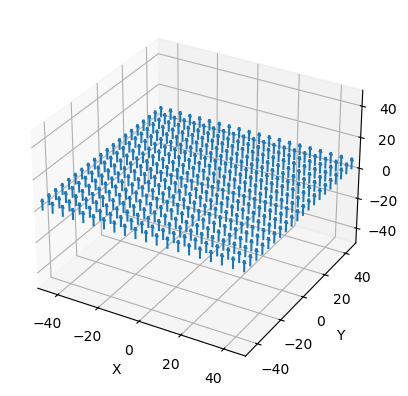

In [25]:
ax = plt.figure().add_subplot(projection='3d')
x, y, z = np.meshgrid(np.arange(-x_sample_size/nm/2+x_discretization_size/nm/2, x_sample_size/nm/2, x_discretization_size/nm),
                      np.arange(-y_sample_size/nm/2+y_discretization_size/nm/2, y_sample_size/nm/2, y_discretization_size/nm),
                      np.arange(-z_sample_size/nm/2+z_discretization_size/nm/2, z_sample_size/nm/2, z_discretization_size/nm))

u = M_array_cartesian[:,:,:,0]
v = M_array_cartesian[:,:,:,1]
w = M_array_cartesian[:,:,:,2]

ax.quiver(x, y, z, u, v, w, length=0.75*z_discretization_size/nm, normalize=False)
ax.set_xlim(-x_sample_size/nm/2, x_sample_size/nm/2)
ax.set_ylim(-y_sample_size/nm/2, y_sample_size/nm/2)
ax.set_zlim(-50, 50)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

## Calculate magnetic field from sample at an arbitract point in space

The total magnetic field at a point $(x, y, z)$ from all dipoles in the sample is given by
$$
\vec{B}(x, y, z) = \sum_i \vec{B}_i(x, y, z)
$$

In [128]:
def B_at_coord_vec_3(coord_calc_arr: np.ndarray, # n_coord x 3
               M_array: np.ndarray, 
               coords_0_arr: np.ndarray,
               sample_dims: Tuple[float, float, float], 
               sample_disc: Tuple[float, float, float], 
               sample_grid: Tuple[int, int, int]
              ) -> Tuple[float, float, float]:
    
    B_vec = np.zeros((3,len(coord_calc_arr)))
    n_coord = len(coord_calc_arr)
    
    center_coord_grid = np.mgrid[0:sample_grid[0], 0:sample_grid[1],0:sample_grid[2]]
    x_0_i_arr = (center_coord_grid[0,:,:,:].copy()*sample_discretization_size[0] -sample_dimensions[0]/2+sample_discretization_size[0]/2).flatten() 
    y_0_i_arr = (center_coord_grid[1,:,:,:].copy()*sample_discretization_size[1] -sample_dimensions[1]/2+sample_discretization_size[1]/2).flatten()
    z_0_i_arr = (center_coord_grid[2,:,:,:].copy()*sample_discretization_size[2] -sample_dimensions[2]/2+sample_discretization_size[2]/2).flatten()

    # extract magnitude and angles
    m_i_arr = M_array[:, :, :, 0].flatten()
    theta_i_arr = M_array[:, :, :, 1].flatten().reshape(-1,1)
    phi_i_arr = M_array[:, :, :, 2].flatten().reshape(-1,1)
    
    # create pairs array
    pairs_array = np.hstack((theta_i_arr, phi_i_arr))
    n_angles = len(pairs_array)
    
    B_components = B_i_vec_3(m_i_arr, coord_calc_arr, coords_0_arr, pairs_array) # dimensions n_ang*n_coord x 3
    B_vec = np.sum(B_components.reshape((n_coord, n_angles, 3)), axis = 1)

    return B_vec

### Sanity checks

In [37]:

coord_calc_arr = np.array([[0, 0, dist_to_sample]])
print("Field components at (0,0,d)", B_at_coord_vec_3(coord_calc_arr, M_array, sample_dimensions, sample_discretization_size, sample_grid))

#coord_calc = (dist_to_sample, dist_to_sample, dist_to_sample)
#print("Field components at (d,d,d)", B_at_coord(coord_calc, M_array, sample_dimensions, sample_discretization_size, sample_grid))

#coord_calc = (-dist_to_sample, -dist_to_sample, dist_to_sample)
#print("Field components at (-d,-d,d)", B_at_coord(coord_calc, M_array, sample_dimensions, sample_discretization_size, sample_grid))

coord_calc_arr = np.array([[dist_to_sample, 0, 0]])
print("Field components at (d,0,0)", B_at_coord_vec_3(coord_calc_arr, M_array, sample_dimensions, sample_discretization_size, sample_grid))

coord_calc_arr = np.array([[0, 0, 10*dist_to_sample]])
print("Field components at (0,0,10d)", B_at_coord_vec_3(coord_calc_arr, M_array, sample_dimensions, sample_discretization_size, sample_grid))

Field components at (0,0,d) [[5.55419922e-03 5.43212891e-03 6.27450678e+14]]
Field components at (d,0,0) [[ 0.00000000e+00  0.00000000e+00 -3.24815557e+14]]
Field components at (0,0,10d) [[6.78002834e-07 4.65661287e-07 6.39872342e+11]]


## Define probe and fluctuations

The SQUID probe is modelled as a square of dimensions $s_{probe} \times s_{probe}$. Its center is placed at some coordinate $(x_{probe}, y_{probe}, d_{probe})$ where $x_{probe}$ and $y_{probe}$ are updated in increments of $\Delta x$ and $\Delta y$. The area of the probe is discretized into squares of size $\Delta a \times \Delta a$, and we calculate the magnetic field at the center of each of these blocks and obtain the flux by taking the $z$-component of the field and writing $\Phi_{ij} = B_z(x_{probe}-s_{probe/2}+\Delta a*(i+0.5), y_{probe}-s_{probe/2}+\Delta a*(j+0.5), d_{probe})*(\Delta a)^2$. The full flux measured by the probe is then $\Phi = \sum_i \sum_j \Phi_{ij}$

In [35]:
probe_side = 50*nm
dist_to_sample = 500*nm

probe_area = probe_side**2

delta_a = 2*nm
del_x = 5*nm
del_y = 5*nm

## Calculating magnetic flux through SQUID loop at distance d above sample center

In [39]:
# vectorized
meshing_probe = (int(probe_side/delta_a), int(probe_side/delta_a)) # nx, ny
da_probe = probe_side/meshing_probe[0]
coord_calc = (0, 0, dist_to_sample)

xt, yt = np.meshgrid(np.arange(meshing_probe[0]), np.arange(meshing_probe[1]))

coord_calc_array = np.zeros((meshing_probe[0]*meshing_probe[1],3))
coord_calc_array[:,0] = coord_calc[0]-probe_side/2 + delta_a*(xt.flatten() + 0.5)
coord_calc_array[:,1] = coord_calc[1]-probe_side/2 + delta_a*(yt.flatten() + 0.5)
coord_calc_array[:,2] = coord_calc[2]

B_probe_units = B_at_coord_vec_3(coord_calc_array, M_array, sample_dimensions, sample_discretization_size, sample_grid)

B_probe_z = B_probe_units[:,2]
flux_arr = B_probe_z.reshape(meshing_probe)*(da_probe**2)


### Plotting magnetic flux per unit cell of probe meshing

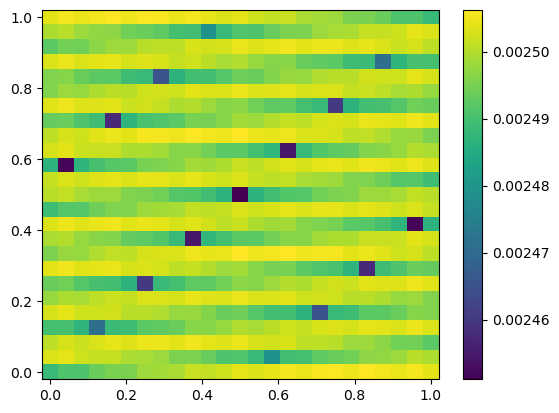

In [42]:
fig, ax = plt.subplots()
im = plt.pcolormesh(np.linspace(0,1,meshing_probe[0]), np.linspace(0,1,meshing_probe[1]), flux_arr)
fig.colorbar(im, ax=ax)

# why stripes? would have expected rotational invariance

In [44]:
# flux through loop roughly the same regarless of probe meshing
flux_through_loop = np.sum(flux_arr)
flux_through_loop

1.5611007619134054

## Sweeping the position of the SQUID loop and calculating the flux

In [46]:
x_min_probe_sweep = -100*nm
x_max_probe_sweep = 100*nm
y_min_probe_sweep = -100*nm
y_max_probe_sweep = 100*nm

nx_sweep = int((x_max_probe_sweep-x_min_probe_sweep)/del_x)
ny_sweep = int((y_max_probe_sweep-y_min_probe_sweep)/del_y)

x_probe_sweep = np.linspace(x_min_probe_sweep, x_max_probe_sweep, num=nx_sweep)
y_probe_sweep = np.linspace(y_min_probe_sweep, y_max_probe_sweep, num=ny_sweep)

flux_results = np.zeros((nx_sweep, ny_sweep))

for ix, x_p in enumerate(x_probe_sweep):
    for iy, y_p in enumerate(y_probe_sweep):
        if ix%10 == 0 and iy%10 == 0:
            print(ix, iy)
        meshing_probe = (int(probe_side/delta_a), int(probe_side/delta_a)) # nx, ny
        da_probe = probe_side/meshing_probe[0]
        coord_calc = (x_p, y_p, dist_to_sample)

        xt, yt = np.meshgrid(np.arange(meshing_probe[0]), np.arange(meshing_probe[1]))

        coord_calc_array = np.zeros((meshing_probe[0]*meshing_probe[1],3))
        coord_calc_array[:,0] = coord_calc[0]-probe_side/2 + delta_a*(xt.flatten() + 0.5)
        coord_calc_array[:,1] = coord_calc[1]-probe_side/2 + delta_a*(yt.flatten() + 0.5)
        coord_calc_array[:,2] = coord_calc[2]

        B_probe_units = B_at_coord_vec_3(coord_calc_array, M_array, sample_dimensions, sample_discretization_size, sample_grid)

        B_probe_z = B_probe_units[:,2]
        flux_arr = B_probe_z.reshape(meshing_probe)*(da_probe**2)
        flux_results[ix, iy] = np.sum(flux_arr)
        
                            
                            

0 0
0 10
0 20
0 30
10 0
10 10
10 20
10 30
20 0
20 10
20 20
20 30
30 0
30 10
30 20
30 30


Below is a color plot of the measured flux by the probe as a function of its position in the xy plane

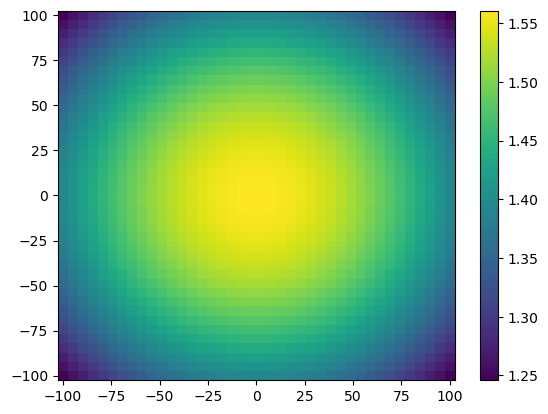

In [47]:
fig, ax = plt.subplots()
im = plt.pcolormesh(np.linspace(-100,100,nx_sweep), np.linspace(-100,100,ny_sweep), flux_results)
fig.colorbar(im, ax=ax)

In [48]:
#np.savetxt('flux_arr_1.txt', flux_results)

## Generating rotated samples

The below function generates a ferromagnetic block in the manner described above. It then places the sample at random orientation $(\Delta \theta, \Delta \phi)$ and repeats the process $n_{samples}$ times returning data for $n_{samples}$ blocks (see sanity check 3 for illustration).

In [56]:
def generate_rotated_ferromagnets(sample_sizes: Tuple[float, float, float], 
                                 discretization_sizes: Tuple[float, float, float],
                                 number_of_samples: int,
                                 m_i_uniform_magnitude: float) -> Tuple[np.ndarray, np.ndarray]:
    
    x_sample_size, y_sample_size, z_sample_size = sample_sizes
    x_discretization_size, y_discretization_size, z_discretization_size = discretization_sizes
    
    nx = int(x_sample_size/x_discretization_size)
    ny = int(y_sample_size/y_discretization_size)
    nz = int(z_sample_size/z_discretization_size)
    
    n_dipoles = nx*ny*nz
    
    center_coord_grid = np.mgrid[0:nx, 0:ny, 0:nz]
    x_0_i_arr = (center_coord_grid[0,:,:,:].copy()*x_discretization_size -x_sample_size/2+x_discretization_size/2).flatten() 
    y_0_i_arr = (center_coord_grid[1,:,:,:].copy()*y_discretization_size -y_sample_size/2+y_discretization_size/2).flatten()
    z_0_i_arr = (center_coord_grid[2,:,:,:].copy()*z_discretization_size -z_sample_size/2+z_discretization_size/2).flatten()
    coords_0_array = np.column_stack((x_0_i_arr, y_0_i_arr, z_0_i_arr)) #.reshape((nx,ny,nz, 3))
    
    M_array = np.zeros((nx, ny, nz, 3))
    M_array[:,:,:,0] = np.ones((nx, ny, nz))*m_i_uniform_magnitude
    M_array[:,:,:,1] = np.ones((nx, ny, nz))
    M_array[:,:,:,2] = np.ones((nx, ny, nz))
    
    M_array_cartesian = np.ones_like(M_array) 
    M_array_cartesian[:,:,:,2] = np.multiply(M_array[:,:,:,0], np.cos(M_array[:,:,:,1]))
    M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_array[:,:,:,0], np.sin(M_array[:,:,:,1])), np.cos(M_array[:,:,:,2]))
    M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_array[:,:,:,0], np.sin(M_array[:,:,:,1])), np.sin(M_array[:,:,:,2]))
    
    M_array_rotated = np.zeros((number_of_samples, nx, ny, nz, 3))
    center_coords_rotated = np.zeros((number_of_samples, nx, ny, nz, 3))
    
    for i in range(number_of_samples):
        theta_i_N = np.random.rand()*np.pi*2
        phi_i_N = np.random.rand()*np.pi*2
        
        M_array_rotated[i,:,:,:,0] = np.ones((nx, ny, nz))*m_i_uniform_magnitude
        M_array_rotated[i,:,:,:,1] = np.ones((nx, ny, nz))*theta_i_N
        M_array_rotated[i,:,:,:,2] = np.ones((nx, ny, nz))*phi_i_N
        
        angle_single_pair = np.array([theta_i_N, phi_i_N])
        angles_tuple = np.array(list(map(np.copy, [angle_single_pair] * n_dipoles)))
        angles_extended = angles_tuple.reshape((n_dipoles, 2))
        
        rot_matrices = rot_vec(angles_extended)
        rotated_coords_0 = np.einsum('ijk,ikl -> ijl', rot_matrices, coords_0_array.reshape((n_dipoles, 3, 1)))
        
        center_coords_rotated[i,:,:,:,:] = rotated_coords_0.reshape((nx,ny,nz, 3))
        
    return M_array_rotated, center_coords_rotated
        
        
        
        

### Santiy Check 1

In [58]:
x_sample_size = 100*nm
y_sample_size = 100*nm
z_sample_size = 10*nm

x_discretization_size = 5*nm
y_discretization_size = 5*nm
z_discretization_size = 10*nm

nx = int(x_sample_size/x_discretization_size)
ny = int(y_sample_size/y_discretization_size)
nz = int(z_sample_size/z_discretization_size)
    
n_dipoles = nx*ny*nz
    
center_coord_grid = np.mgrid[0:nx, 0:ny, 0:nz]
x_0_i_arr = (center_coord_grid[0,:,:,:].copy()*x_discretization_size -x_sample_size/2+x_discretization_size/2).flatten() 
y_0_i_arr = (center_coord_grid[1,:,:,:].copy()*y_discretization_size -y_sample_size/2+y_discretization_size/2).flatten()
z_0_i_arr = (center_coord_grid[2,:,:,:].copy()*z_discretization_size -z_sample_size/2+z_discretization_size/2).flatten()
coords_0_array = np.column_stack((x_0_i_arr, y_0_i_arr, z_0_i_arr)).reshape((nx,ny,nz, 3)) #.reshape((n_dipoles, 3))

In [60]:
print('If we rotate the plane by theta=np.pi/2 phi=np.pi/2, we expect the corners to move from the xy plane to the xz plane with the (-,-,0) corner at (+,0, +)')

test_rot = np.linalg.inv(rot_vec(np.array([[-np.pi/2, -np.pi/2]])))
test_vec = coords_0_array[0,0,0,:]
print('We obtain: ', np.matmul(test_rot, test_vec))

print('If we rotate the plane by theta=np.pi/2 phi=np.pi/2, we expect the corners to move from the xy plane to the xz plane with the (+,-,0) corner at (+,0,-)')

test_rot = np.linalg.inv(rot_vec(np.array([[-np.pi/2, -np.pi/2]])))
test_vec = coords_0_array[-1,0,0,:]
print('We obtain: ', np.matmul(test_rot, test_vec))

If we rotate the plane by theta=np.pi/2 phi=np.pi/2, we expect the corners to move from the xy plane to the xz plane with the (-,-,0) corner at (+,0, +)
We obtain:  [[ 4.7500000e-08 -5.8170723e-24  4.7500000e-08]]
If we rotate the plane by theta=np.pi/2 phi=np.pi/2, we expect the corners to move from the xy plane to the xz plane with the (+,-,0) corner at (+,0,-)
We obtain:  [[ 4.75e-08  0.00e+00 -4.75e-08]]


### Sanity Check 2

In [109]:
sample_sizes = (1*nm, 1*nm, 1*nm)
discretization_sizes = (1*nm, 1*nm, 1*nm)
number_of_samples = 1
m_i_uniform_magnitude = 1.0

M_arr_rot, coord_arr_rot = generate_rotated_ferromagnets(sample_sizes, 
                                 discretization_sizes,
                                 number_of_samples,
                                 m_i_uniform_magnitude)

print('Should have a rotated M_array but zero vector for coords_0.')
print('We obtain:')
print('M_array =', M_arr_rot)
print('coords_0 =', coord_arr_rot)

Should have a rotated M_array but zero vector for coords_0.
We obtain:
M_array = [[[[[1.         2.20335203 0.31242871]]]]]
coords_0 = [[[[[0. 0. 0.]]]]]


In [62]:
sample_sizes = (2*nm, 2*nm, 1*nm)
discretization_sizes = (1*nm, 1*nm, 1*nm)
number_of_samples = 1
m_i_uniform_magnitude = 1.0

M_arr_rot, coord_arr_rot = generate_rotated_ferromagnets(sample_sizes, 
                                 discretization_sizes,
                                 number_of_samples,
                                 m_i_uniform_magnitude)

print('Should have a rotated M_array and the corner vectors will contain symmetries.')
print('We obtain:')
print('M_array =', M_arr_rot)
print('coords_0 =', coord_arr_rot/nm)

Should have a rotated M_array and the corner vectors will contain symmetries.
We obtain:
M_array = [[[[[1.         0.79943886 1.26127179]]

   [[1.         0.79943886 1.26127179]]]


  [[[1.         0.79943886 1.26127179]]

   [[1.         0.79943886 1.26127179]]]]]
coords_0 = [[[[[ 0.22581899 -0.62854215 -0.23225104]]

   [[-0.43816248 -0.32393635  0.45064274]]]


  [[[ 0.43816248  0.32393635 -0.45064274]]

   [[-0.22581899  0.62854215  0.23225104]]]]]


### Sanity Check 3

Text(0.5, 0, 'Z')

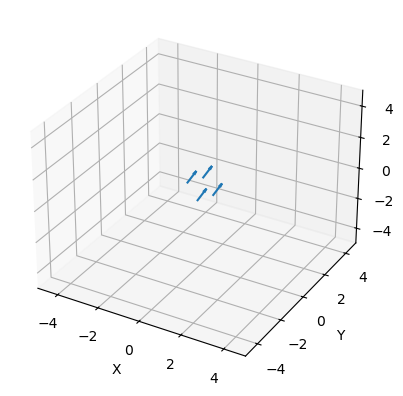

In [90]:

ax = plt.figure().add_subplot(projection='3d')

x = coord_arr_rot[:,:,:,0,0]/nm
y = coord_arr_rot[:,:,:,0,1]/nm
z = coord_arr_rot[:,:,:,0,2]/nm

X, Y, Z = np.meshgrid(x, y, z)

M_array_cartesian = np.ones_like(M_arr_rot[:,:,:,0,:]) 
M_array_cartesian[:,:,:,2] = np.multiply(M_arr_rot[:,:,:,0,0], np.cos(M_arr_rot[:,:,:,0,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_arr_rot[:,:,:,0,0], np.sin(M_arr_rot[:,:,:,0,1])), np.cos(M_arr_rot[:,:,:,0,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_arr_rot[:,:,:,0,0], np.sin(M_arr_rot[:,:,:,0,1])), np.sin(M_arr_rot[:,:,:,0,2]))

u = M_array_cartesian[:,:,:,0]
v = M_array_cartesian[:,:,:,1]
w = M_array_cartesian[:,:,:,2]

ax.quiver(x, y, z, u, v, w, length=0.75*z_discretization_size/nm, normalize=False)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [ ]:
 # COPY CODE BLOCK ACCIDENTALLY DELETED

Text(0.5, 0, 'Z')

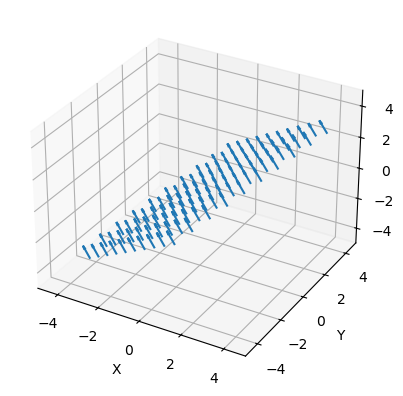

In [94]:
ax = plt.figure().add_subplot(projection='3d')

x = coord_arr_rot[:,:,:,0,0]/nm
y = coord_arr_rot[:,:,:,0,1]/nm
z = coord_arr_rot[:,:,:,0,2]/nm

X, Y, Z = np.meshgrid(x, y, z)

M_array_cartesian = np.ones_like(M_arr_rot[:,:,:,0,:]) 
M_array_cartesian[:,:,:,2] = np.multiply(M_arr_rot[:,:,:,0,0], np.cos(M_arr_rot[:,:,:,0,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_arr_rot[:,:,:,0,0], np.sin(M_arr_rot[:,:,:,0,1])), np.cos(M_arr_rot[:,:,:,0,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_arr_rot[:,:,:,0,0], np.sin(M_arr_rot[:,:,:,0,1])), np.sin(M_arr_rot[:,:,:,0,2]))

u = M_array_cartesian[:,:,:,0]
v = M_array_cartesian[:,:,:,1]
w = M_array_cartesian[:,:,:,2]

ax.quiver(x, y, z, u, v, w, length=0.75*z_discretization_size/nm, normalize=False)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Flux sweep for each rotated sample

In this section, we put the pieces above together and generate data for flux sweeps of each rotated sample. See sanity check below for illustration.

## Sanity check for 4 samples

In [106]:
sample_sizes = (10*nm, 10*nm, 2*nm)
discretization_sizes = (1*nm, 1*nm, 1*nm)

nx = int(sample_sizes[0]/discretization_sizes[0])
ny = int(sample_sizes[1]/discretization_sizes[1])
nz = int(sample_sizes[2]/discretization_sizes[2])

sample_grid = (nx, ny, nz)

number_of_samples = 4
m_i_uniform_magnitude = 1.0

M_arr_rot, coord_arr_rot = generate_rotated_ferromagnets(sample_sizes, 
                                 discretization_sizes,
                                 number_of_samples,
                                 m_i_uniform_magnitude)

In [130]:
x_min_probe_sweep = -20*nm
x_max_probe_sweep = 20*nm
y_min_probe_sweep = -20*nm
y_max_probe_sweep = 20*nm

del_x = 1*nm
del_y = 1*nm

probe_side = 30*nm
delta_a = 1*nm

dist_to_sample = 100*nm

nx_sweep = int((x_max_probe_sweep-x_min_probe_sweep)/del_x)
ny_sweep = int((y_max_probe_sweep-y_min_probe_sweep)/del_y)

x_probe_sweep = np.linspace(x_min_probe_sweep, x_max_probe_sweep, num=nx_sweep)
y_probe_sweep = np.linspace(y_min_probe_sweep, y_max_probe_sweep, num=ny_sweep)

flux_results = np.zeros((number_of_samples, nx_sweep, ny_sweep))

for i_sample in range(number_of_samples):
    print('SAMPLE ', i_sample, ' OUT OF ', number_of_samples)
    M_this_sample = M_arr_rot[i_sample,:,:,:,:] #.reshape((nx*ny*nz, 3))
    coord_arr_this_sample = coord_arr_rot[i_sample,:,:,:,:].reshape((nx*ny*nz, 3))

    for ix, x_p in enumerate(x_probe_sweep):
        for iy, y_p in enumerate(y_probe_sweep):
            if ix%10 == 0 and iy%10 == 0:
                print(ix, iy)
            meshing_probe = (int(probe_side/delta_a), int(probe_side/delta_a)) # nx, ny
            da_probe = probe_side/meshing_probe[0]
            coord_calc = (x_p, y_p, dist_to_sample)
    
            xt, yt = np.meshgrid(np.arange(meshing_probe[0]), np.arange(meshing_probe[1]))
    
            coord_calc_array = np.zeros((meshing_probe[0]*meshing_probe[1],3))
            coord_calc_array[:,0] = coord_calc[0]-probe_side/2 + delta_a*(xt.flatten() + 0.5)
            coord_calc_array[:,1] = coord_calc[1]-probe_side/2 + delta_a*(yt.flatten() + 0.5)
            coord_calc_array[:,2] = coord_calc[2]
    
            B_probe_units = B_at_coord_vec_3(coord_calc_array, M_this_sample, coord_arr_this_sample, sample_sizes, discretization_sizes, sample_grid)
    
            B_probe_z = B_probe_units[:,2]
            flux_arr = B_probe_z.reshape(meshing_probe)*(da_probe**2)
            flux_results[i_sample, ix, iy] = np.sum(flux_arr)

    
    

SAMPLE  0  OUT OF  4
0 0
0 10
0 20
0 30
10 0
10 10
10 20
10 30
20 0
20 10
20 20
20 30
30 0
30 10
30 20
30 30
SAMPLE  1  OUT OF  4
0 0
0 10
0 20
0 30
10 0
10 10
10 20
10 30
20 0
20 10
20 20
20 30
30 0
30 10
30 20
30 30
SAMPLE  2  OUT OF  4
0 0
0 10
0 20
0 30
10 0
10 10
10 20
10 30
20 0
20 10
20 20
20 30
30 0
30 10
30 20
30 30
SAMPLE  3  OUT OF  4
0 0
0 10
0 20
0 30
10 0
10 10
10 20
10 30
20 0
20 10
20 20
20 30
30 0
30 10
30 20
30 30


Text(0.5, 0, 'Z')

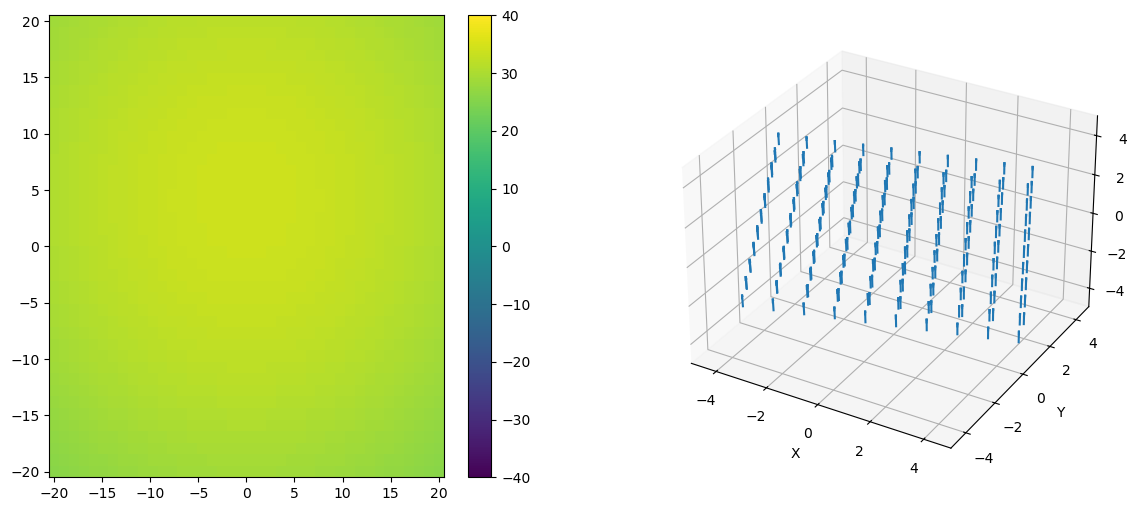

In [187]:
fig= plt.figure(figsize=(14,6))
ax1=fig.add_subplot(121)
norm = mlp.colors.Normalize(vmin=-40, vmax=40)
im = plt.pcolormesh(np.linspace(x_min_probe_sweep/nm,x_max_probe_sweep/nm,nx_sweep), np.linspace(y_min_probe_sweep/nm,y_max_probe_sweep/nm,ny_sweep), flux_results[0,:,:], norm=norm)
fig.colorbar(im, ax=ax1)

ax1.set_title('Magnetic flux as a function of position (x, y, d=100 nm)')

ax2 = fig.add_subplot(122, projection='3d')

x = coord_arr_rot[0,:,:,:,0]/nm
y = coord_arr_rot[0,:,:,:,1]/nm
z = coord_arr_rot[0,:,:,:,2]/nm

M_array_cartesian = np.ones_like(M_arr_rot[0,:,:,:,:]) 
M_array_cartesian[:,:,:,2] = np.multiply(M_arr_rot[0,:,:,:,0], np.cos(M_arr_rot[0,:,:,:,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_arr_rot[0,:,:,:,0], np.sin(M_arr_rot[0,:,:,:,1])), np.cos(M_arr_rot[0,:,:,:,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_arr_rot[0,:,:,:,0], np.sin(M_arr_rot[0,:,:,:,1])), np.sin(M_arr_rot[0,:,:,:,2]))

u = M_array_cartesian[:,:,:,0]
v = M_array_cartesian[:,:,:,1]
w = M_array_cartesian[:,:,:,2]

ax2.quiver(x, y, z, u, v, w, length=0.75*z_discretization_size/nm, normalize=False)
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)
ax2.set_zlim(-5, 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

Text(0.5, 0, 'Z')

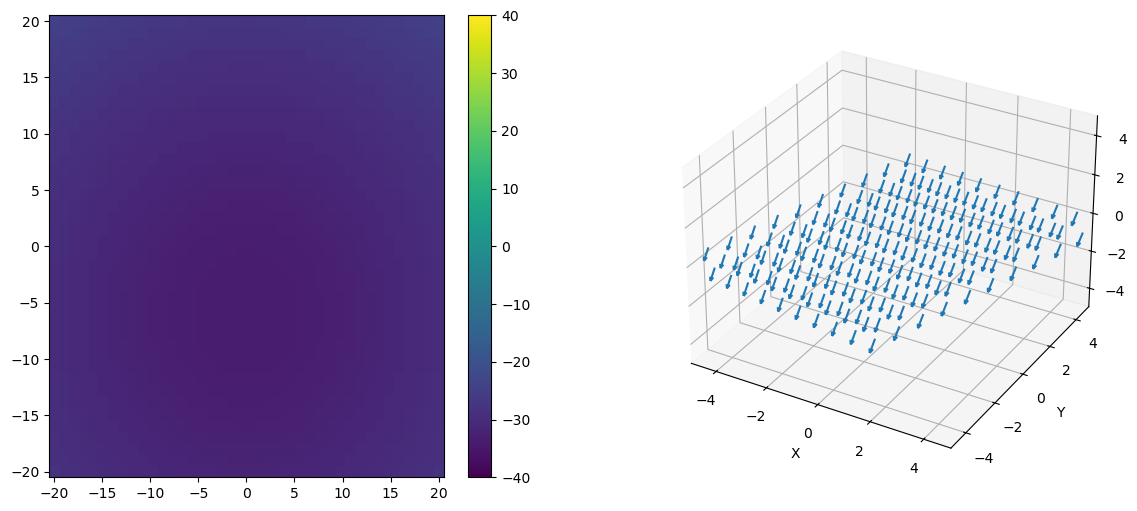

In [189]:
i_sample_num = 1

fig= plt.figure(figsize=(14,6))
ax1=fig.add_subplot(121)
norm = mlp.colors.Normalize(vmin=-40, vmax=40)
im = plt.pcolormesh(np.linspace(x_min_probe_sweep/nm,x_max_probe_sweep/nm,nx_sweep), np.linspace(y_min_probe_sweep/nm,y_max_probe_sweep/nm,ny_sweep), flux_results[i_sample_num,:,:], norm=norm)
fig.colorbar(im, ax=ax1)
ax1.set_title('Magnetic flux as a function of position (x, y, d=100 nm)')

ax2 = fig.add_subplot(122, projection='3d')


x = coord_arr_rot[i_sample_num,:,:,:,0]/nm
y = coord_arr_rot[i_sample_num,:,:,:,1]/nm
z = coord_arr_rot[i_sample_num,:,:,:,2]/nm

M_array_cartesian = np.ones_like(M_arr_rot[i_sample_num,:,:,:,:]) 
M_array_cartesian[:,:,:,2] = np.multiply(M_arr_rot[i_sample_num,:,:,:,0], np.cos(M_arr_rot[i_sample_num,:,:,:,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_arr_rot[i_sample_num,:,:,:,0], np.sin(M_arr_rot[i_sample_num,:,:,:,1])), np.cos(M_arr_rot[i_sample_num,:,:,:,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_arr_rot[i_sample_num,:,:,:,0], np.sin(M_arr_rot[i_sample_num,:,:,:,1])), np.sin(M_arr_rot[i_sample_num,:,:,:,2]))

u = M_array_cartesian[:,:,:,0]
v = M_array_cartesian[:,:,:,1]
w = M_array_cartesian[:,:,:,2]

ax2.quiver(x, y, z, u, v, w, length=0.75*z_discretization_size/nm, normalize=False)
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)
ax2.set_zlim(-5, 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

Text(0.5, 0, 'Z')

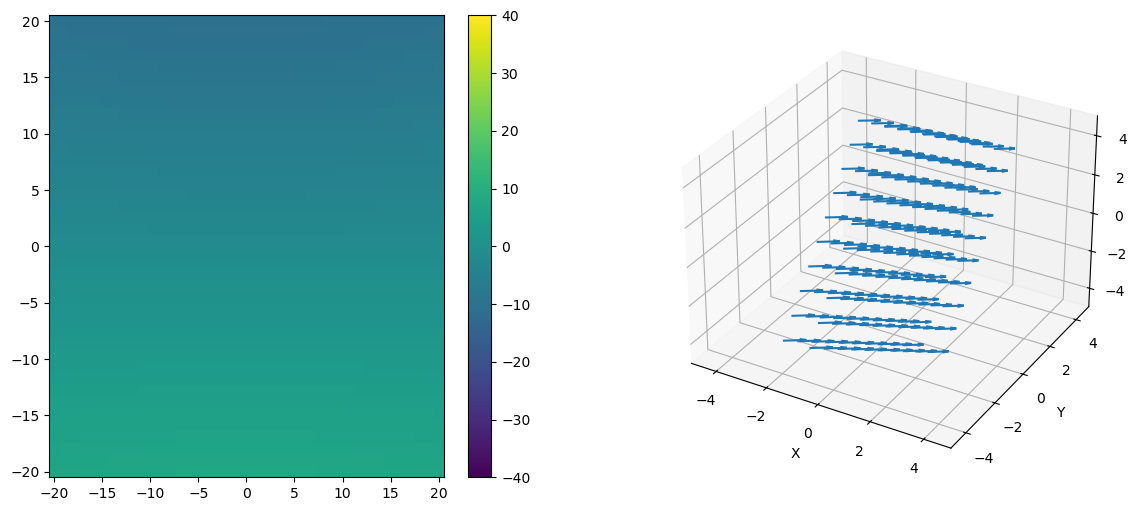

In [191]:
i_sample_num = 2

fig= plt.figure(figsize=(14,6))
ax1=fig.add_subplot(121)
norm = mlp.colors.Normalize(vmin=-40, vmax=40)
im = plt.pcolormesh(np.linspace(x_min_probe_sweep/nm,x_max_probe_sweep/nm,nx_sweep), np.linspace(y_min_probe_sweep/nm,y_max_probe_sweep/nm,ny_sweep), flux_results[i_sample_num,:,:], norm=norm)
fig.colorbar(im, ax=ax1)
ax1.set_title('Magnetic flux as a function of position (x, y, d=100 nm)')

ax2 = fig.add_subplot(122, projection='3d')


x = coord_arr_rot[i_sample_num,:,:,:,0]/nm
y = coord_arr_rot[i_sample_num,:,:,:,1]/nm
z = coord_arr_rot[i_sample_num,:,:,:,2]/nm

M_array_cartesian = np.ones_like(M_arr_rot[i_sample_num,:,:,:,:]) 
M_array_cartesian[:,:,:,2] = np.multiply(M_arr_rot[i_sample_num,:,:,:,0], np.cos(M_arr_rot[i_sample_num,:,:,:,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_arr_rot[i_sample_num,:,:,:,0], np.sin(M_arr_rot[i_sample_num,:,:,:,1])), np.cos(M_arr_rot[i_sample_num,:,:,:,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_arr_rot[i_sample_num,:,:,:,0], np.sin(M_arr_rot[i_sample_num,:,:,:,1])), np.sin(M_arr_rot[i_sample_num,:,:,:,2]))

u = M_array_cartesian[:,:,:,0]
v = M_array_cartesian[:,:,:,1]
w = M_array_cartesian[:,:,:,2]

ax2.quiver(x, y, z, u, v, w, length=0.75*z_discretization_size/nm, normalize=False)
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)
ax2.set_zlim(-5, 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

Text(0.5, 0, 'Z')

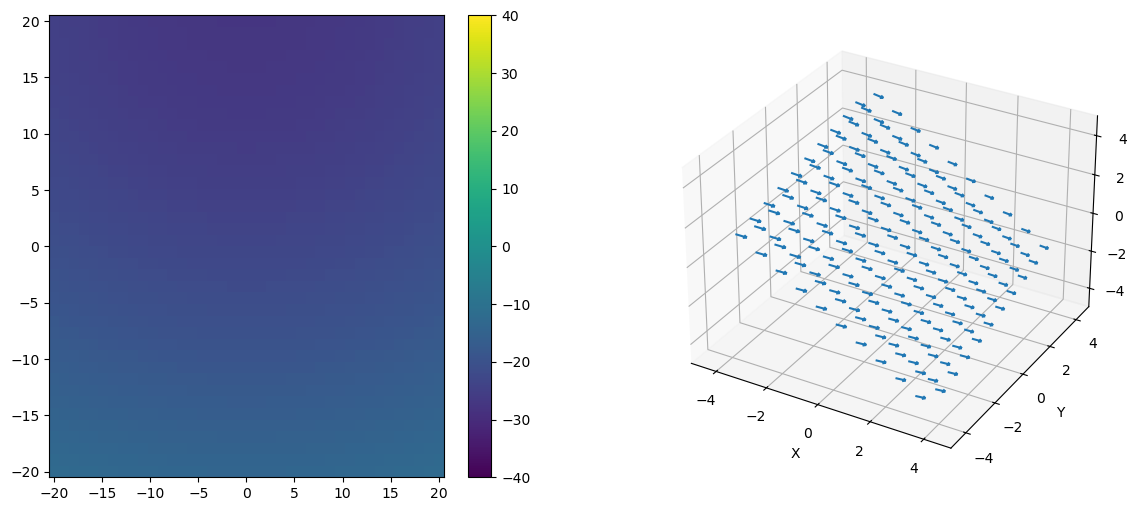

In [193]:
i_sample_num = 3

fig= plt.figure(figsize=(14,6))
ax1=fig.add_subplot(121)
norm = mlp.colors.Normalize(vmin=-40, vmax=40)
im = plt.pcolormesh(np.linspace(x_min_probe_sweep/nm,x_max_probe_sweep/nm,nx_sweep), np.linspace(y_min_probe_sweep/nm,y_max_probe_sweep/nm,ny_sweep), flux_results[i_sample_num,:,:], norm=norm)
fig.colorbar(im, ax=ax1)
ax1.set_title('Magnetic flux as a function of position (x, y, d=100 nm)')

ax2 = fig.add_subplot(122, projection='3d')


x = coord_arr_rot[i_sample_num,:,:,:,0]/nm
y = coord_arr_rot[i_sample_num,:,:,:,1]/nm
z = coord_arr_rot[i_sample_num,:,:,:,2]/nm

M_array_cartesian = np.ones_like(M_arr_rot[i_sample_num,:,:,:,:]) 
M_array_cartesian[:,:,:,2] = np.multiply(M_arr_rot[i_sample_num,:,:,:,0], np.cos(M_arr_rot[i_sample_num,:,:,:,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_arr_rot[i_sample_num,:,:,:,0], np.sin(M_arr_rot[i_sample_num,:,:,:,1])), np.cos(M_arr_rot[i_sample_num,:,:,:,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_arr_rot[i_sample_num,:,:,:,0], np.sin(M_arr_rot[i_sample_num,:,:,:,1])), np.sin(M_arr_rot[i_sample_num,:,:,:,2]))

u = M_array_cartesian[:,:,:,0]
v = M_array_cartesian[:,:,:,1]
w = M_array_cartesian[:,:,:,2]

ax2.quiver(x, y, z, u, v, w, length=0.75*z_discretization_size/nm, normalize=False)
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)
ax2.set_zlim(-5, 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

## Generating training sample

In [195]:
sample_sizes = (10*nm, 10*nm, 2*nm)
discretization_sizes = (1*nm, 1*nm, 1*nm)

nx = int(sample_sizes[0]/discretization_sizes[0])
ny = int(sample_sizes[1]/discretization_sizes[1])
nz = int(sample_sizes[2]/discretization_sizes[2])

sample_grid = (nx, ny, nz)

number_of_samples = 10_000
m_i_uniform_magnitude = 1.0

M_arr_rot, coord_arr_rot = generate_rotated_ferromagnets(sample_sizes, 
                                 discretization_sizes,
                                 number_of_samples,
                                 m_i_uniform_magnitude)

In [201]:
#np.save('coord_arr_Dec_2n.npy', coord_arr_rot)

In [ ]:
x_min_probe_sweep = -20*nm
x_max_probe_sweep = 20*nm
y_min_probe_sweep = -20*nm
y_max_probe_sweep = 20*nm

del_x = 1*nm
del_y = 1*nm

probe_side = 30*nm
delta_a = 1*nm

dist_to_sample = 100*nm

nx_sweep = int((x_max_probe_sweep-x_min_probe_sweep)/del_x)
ny_sweep = int((y_max_probe_sweep-y_min_probe_sweep)/del_y)

x_probe_sweep = np.linspace(x_min_probe_sweep, x_max_probe_sweep, num=nx_sweep)
y_probe_sweep = np.linspace(y_min_probe_sweep, y_max_probe_sweep, num=ny_sweep)

flux_results = np.zeros((number_of_samples, nx_sweep, ny_sweep))

for i_sample in range(number_of_samples):
    print('SAMPLE ', i_sample, ' OUT OF ', number_of_samples)
    M_this_sample = M_arr_rot[i_sample,:,:,:,:] #.reshape((nx*ny*nz, 3))
    coord_arr_this_sample = coord_arr_rot[i_sample,:,:,:,:].reshape((nx*ny*nz, 3))

    for ix, x_p in enumerate(x_probe_sweep):
        for iy, y_p in enumerate(y_probe_sweep):
            #if ix%10 == 0 and iy%10 == 0:
            #    print(ix, iy)
            meshing_probe = (int(probe_side/delta_a), int(probe_side/delta_a)) # nx, ny
            da_probe = probe_side/meshing_probe[0]
            coord_calc = (x_p, y_p, dist_to_sample)
    
            xt, yt = np.meshgrid(np.arange(meshing_probe[0]), np.arange(meshing_probe[1]))
    
            coord_calc_array = np.zeros((meshing_probe[0]*meshing_probe[1],3))
            coord_calc_array[:,0] = coord_calc[0]-probe_side/2 + delta_a*(xt.flatten() + 0.5)
            coord_calc_array[:,1] = coord_calc[1]-probe_side/2 + delta_a*(yt.flatten() + 0.5)
            coord_calc_array[:,2] = coord_calc[2]
    
            B_probe_units = B_at_coord_vec_3(coord_calc_array, M_this_sample, coord_arr_this_sample, sample_sizes, discretization_sizes, sample_grid)
    
            B_probe_z = B_probe_units[:,2]
            flux_arr = B_probe_z.reshape(meshing_probe)*(da_probe**2)
            flux_results[i_sample, ix, iy] = np.sum(flux_arr)

    
#np.save('flux_results_Dec_2n.npy', flux_results)    

SAMPLE  0  OUT OF  10000
SAMPLE  1  OUT OF  10000
SAMPLE  2  OUT OF  10000
SAMPLE  3  OUT OF  10000
SAMPLE  4  OUT OF  10000
SAMPLE  5  OUT OF  10000
SAMPLE  6  OUT OF  10000
SAMPLE  7  OUT OF  10000
SAMPLE  8  OUT OF  10000
SAMPLE  9  OUT OF  10000
SAMPLE  10  OUT OF  10000
SAMPLE  11  OUT OF  10000
SAMPLE  12  OUT OF  10000
SAMPLE  13  OUT OF  10000
SAMPLE  14  OUT OF  10000
SAMPLE  15  OUT OF  10000
SAMPLE  16  OUT OF  10000
SAMPLE  17  OUT OF  10000
SAMPLE  18  OUT OF  10000
SAMPLE  19  OUT OF  10000
SAMPLE  20  OUT OF  10000
SAMPLE  21  OUT OF  10000
SAMPLE  22  OUT OF  10000
SAMPLE  23  OUT OF  10000
SAMPLE  24  OUT OF  10000
SAMPLE  25  OUT OF  10000
SAMPLE  26  OUT OF  10000
SAMPLE  27  OUT OF  10000
SAMPLE  28  OUT OF  10000
SAMPLE  29  OUT OF  10000
SAMPLE  30  OUT OF  10000
SAMPLE  31  OUT OF  10000
SAMPLE  32  OUT OF  10000
SAMPLE  33  OUT OF  10000
SAMPLE  34  OUT OF  10000
SAMPLE  35  OUT OF  10000
SAMPLE  36  OUT OF  10000
SAMPLE  37  OUT OF  10000
SAMPLE  38  OUT OF  10

# Train model

Though there are sophisticated models better suited for the task of 3D reconstruction, I will start as simple as possible and do a linear regression which can identify the structure of the magnetized sample (number of dipoles, their positions and orientation) given a flux sweep. 

## Train model with both coord_0 and M_arr as targets

In [48]:
import torch

In [80]:
nx = 10
ny = 10
nz = 2

px = 40
py = 40

In [64]:
input_data_loaded = np.load('flux_results_Dec_2n_814_samples.npy')
M_data_loaded =  np.load('M_arr_Dec_2n.npy')
coord_data_loaded =  np.load('coord_arr_Dec_2n.npy')

input_data_updated=input_data_loaded[:814,:,:].copy()
M_data_updated=M_data_loaded[:814,:,:,:,:].copy()
coord_data_updated=coord_data_loaded[:814,:,:,:,:].copy()

In [86]:
input_data_final = input_data_updated.reshape((814, 40*40))
input_data_final = input_data_final.astype(float)

M_and_coord_data = np.concatenate((M_data_updated, coord_data_updated), axis = 4)
target_data_final = M_and_coord_data.reshape((814, 10*10*2*6))
target_data_final = target_data_final.astype(float)

In [101]:
## Adapted from https://medium.com/@aakanksha.ns/linear-regression-using-pytorch-4c1e3b0f4f67

import torch.nn as nn

# Input (px*py)
# Targets (nx*ny*nz*6)

inputs = torch.from_numpy(input_data_final)
targets = torch.from_numpy(target_data_final)

# Import tensor dataset & data loader
from torch.utils.data import TensorDataset, DataLoader

# Define dataset
train_ds = TensorDataset(inputs, targets)

# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

#Define model
model = nn.Linear(int(px*py),int(nx*ny*nz*6), dtype=torch.float64)

#Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

# Import nn.functional
import torch.nn.functional as F

#Define loss function
loss_fn = F.mse_loss
train_losses = []

#Define a utility function to train the model
def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            #Generate predictions
            pred = model(xb)
            loss = loss_fn(pred,yb)
            #Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_fn(model(inputs), targets))
    print('Training loss: ', loss_fn(model(inputs), targets))

#Train the model for 1000 epochs
fit(1000, model, loss_fn, opt)

#Generate predictions
preds = model(inputs)

Training loss:  tensor(4.0891, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [115]:
train_losses_np = [train_losses[i].detach().numpy() for i in range(len(train_losses))]

Text(0, 0.5, 'Loss')

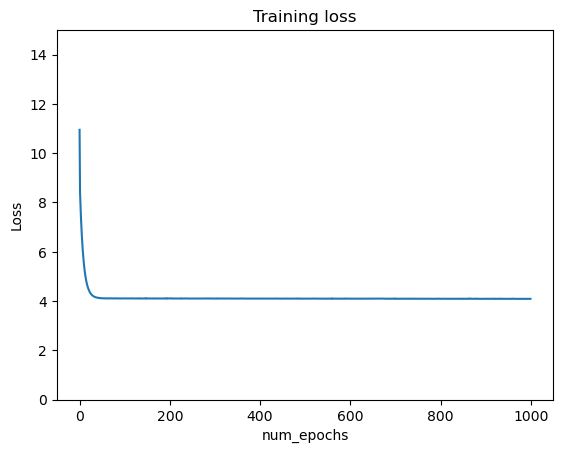

In [127]:
plt.plot(list(range(1000)), train_losses_np)
plt.ylim(0,15)
plt.title('Training loss')
plt.xlabel('num_epochs')
plt.ylabel('Loss')

In [166]:
M_arr_validation = np.load('M_arr_Dec_3rd_500.npy') 
coord_arr_validation = np.load('coord_arr_Dec_3rd_500.npy')

flux_sweep_validation = np.load('flux_results_Dec_3rd_500.npy')

In [131]:
flux_sweep_validation_final = flux_sweep_validation.reshape((500, 40*40))
flux_sweep_validation_final = flux_sweep_validation_final.astype(float)

M_and_coord_validation = np.concatenate((M_arr_validation, coord_arr_validation), axis = 4)
M_and_coord_validation_final = M_and_coord_validation.reshape((500, 10*10*2*6))
M_and_coord_validation_final = M_and_coord_validation_final.astype(float)

In [170]:
inputs_validation = torch.from_numpy(flux_sweep_validation_final)
targets_validation = torch.from_numpy(M_and_coord_validation_final)

print('Validation error: ', loss_fn(model(inputs_validation), targets_validation)) 

Validation error:  tensor(0.3651, dtype=torch.float64, grad_fn=<MseLossBackward0>)


### Visualization of results

In [172]:
index = 1
selected_input = flux_sweep_validation_final[index,:]
selected_M_arr = M_arr_validation[index,:,:,:,:]
selected_coord_arr = coord_arr_validation[index,:,:,:,:]

Text(0.5, 0, 'Z')

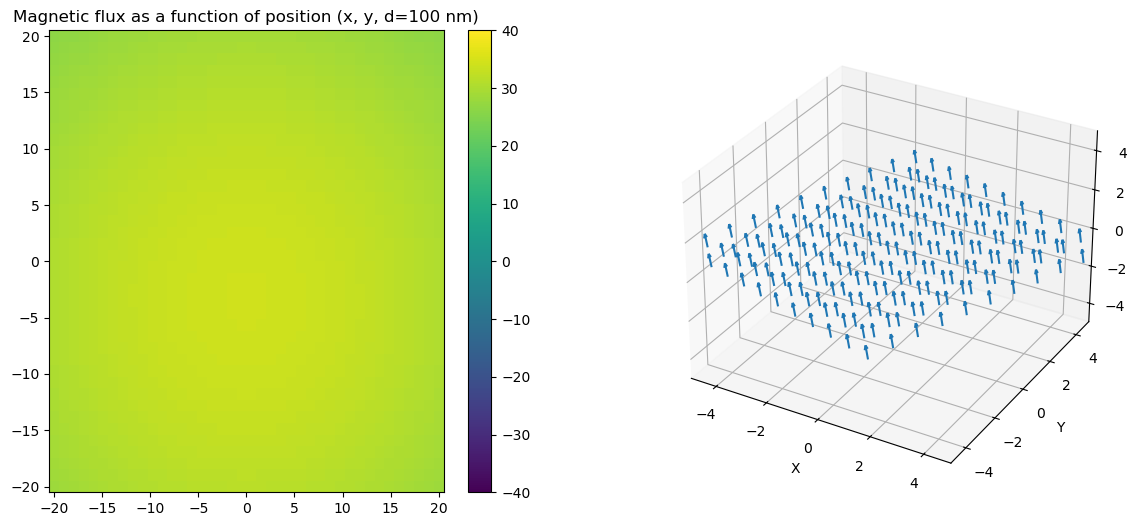

In [174]:
nm=1e-9
fig= plt.figure(figsize=(14,6))
ax1=fig.add_subplot(121)
norm = mlp.colors.Normalize(vmin=-40, vmax=40)
im = plt.pcolormesh(np.linspace(-20,20,40), np.linspace(-20,20,40), flux_sweep_validation[index,:,:], norm=norm)
fig.colorbar(im, ax=ax1)
ax1.set_title('Magnetic flux as a function of position (x, y, d=100 nm)')

ax2 = fig.add_subplot(122, projection='3d')


x = selected_coord_arr[:,:,:,0]/nm
y = selected_coord_arr[:,:,:,1]/nm
z = selected_coord_arr[:,:,:,2]/nm

M_array_cartesian = np.ones_like(selected_M_arr) 
M_array_cartesian[:,:,:,2] = np.multiply(selected_M_arr[:,:,:,0], np.cos(selected_M_arr[:,:,:,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(selected_M_arr[:,:,:,0], np.sin(selected_M_arr[:,:,:,1])), np.cos(selected_M_arr[:,:,:,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(selected_M_arr[:,:,:,0], np.sin(selected_M_arr[:,:,:,1])), np.sin(selected_M_arr[:,:,:,2]))

u = M_array_cartesian[:,:,:,0]
v = M_array_cartesian[:,:,:,1]
w = M_array_cartesian[:,:,:,2]

ax2.quiver(x, y, z, u, v, w, length=0.75*1*nm/nm, normalize=False)
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)
ax2.set_zlim(-5, 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

In [188]:
selected_prediction = model(torch.from_numpy(selected_input))
predicted_M_coord_arr = selected_prediction.detach().numpy().reshape((10,10,2,6))
predicted_M_arr = predicted_M_coord_arr[:,:,:,:3]
predicted_coord_arr = predicted_M_coord_arr[:,:,:,3:]

Text(0.5, 0, 'Z')

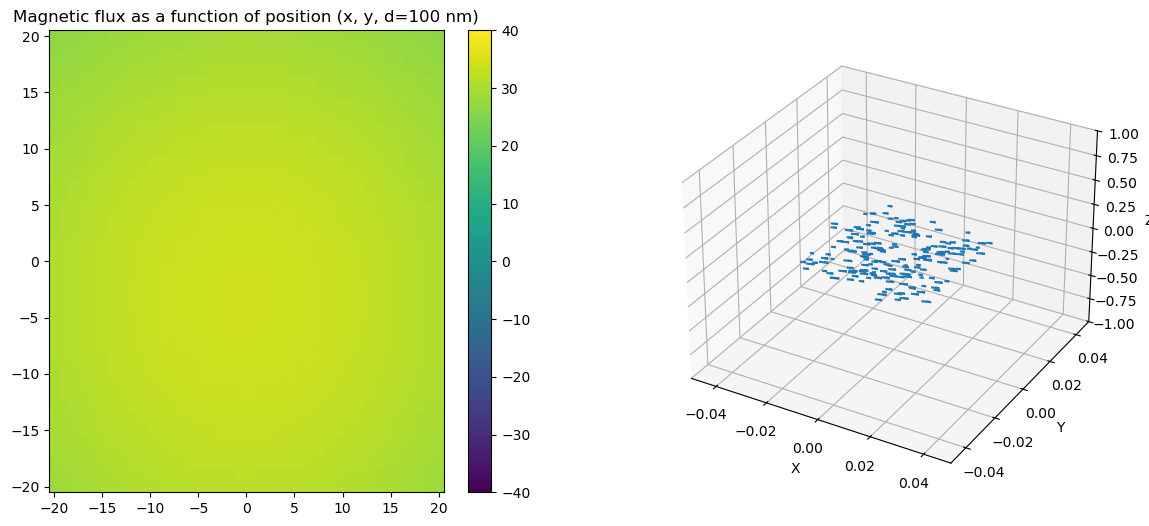

In [240]:
nm=1e-9
fig= plt.figure(figsize=(14,6))
ax1=fig.add_subplot(121)
norm = mlp.colors.Normalize(vmin=-40, vmax=40)
im = plt.pcolormesh(np.linspace(-20,20,40), np.linspace(-20,20,40), flux_sweep_validation[index,:,:], norm=norm)
fig.colorbar(im, ax=ax1)
ax1.set_title('Magnetic flux as a function of position (x, y, d=100 nm)')

ax2 = fig.add_subplot(122, projection='3d')

x = predicted_coord_arr[:,:,:,0]
y = predicted_coord_arr[:,:,:,1]
z = predicted_coord_arr[:,:,:,2]

M_array_cartesian = np.ones_like(predicted_M_arr) 
M_array_cartesian[:,:,:,2] = np.multiply(predicted_M_arr[:,:,:,0], np.cos(predicted_M_arr[:,:,:,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(predicted_M_arr[:,:,:,0], np.sin(predicted_M_arr[:,:,:,1])), np.cos(predicted_M_arr[:,:,:,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(predicted_M_arr[:,:,:,0], np.sin(predicted_M_arr[:,:,:,1])), np.sin(predicted_M_arr[:,:,:,2]))

u = M_array_cartesian[:,:,:,0]
v = M_array_cartesian[:,:,:,1]
w = M_array_cartesian[:,:,:,2]

ax2.quiver(x, y, z, u*1, v*1, w*1, length=0.1, normalize=False)
ax2.set_xlim(-0.05, 0.05)
ax2.set_ylim(-0.05, 0.05)
ax2.set_zlim(-1, 1)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

In this example, it is clear that the model can roughly predict that the dipoles are aranged in a sheet but the scale at which they are placed and their orientation are both off. The issue of scale could be solved by adding a term to the loss function which penalizes minimizig scales beyond some reasonable point. However, the issue of orientation is likely better solved with a different model than the linear regression -- for instance by finding the M_arr that maximizes something like $\sum_{i} p(X{i}|M_arr, \theta, \phi)p(\theta, \phi)$. It can also be noted that the training set here is small (which also explains the poor performance of the training loss) and that creating a larger data set might improve results.